In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Ant System (AS) and Ant Colony System (ACS)

### Ant System (AS)

The **Ant System (AS)** was the first ant algorithm, developed by Dorigo et al. in 1996 for solving the benchmark **Traveling Salesman Problem (TSP)**. The key components of the system are:

- **Pheromone Trail** $ \tau_{ij} $: Represents the pheromone trail between two components (cities) $ i $ and $ j $, which influences the path taken by the ants.
- **Heuristic Information** $ \eta_{ij} $: The desirability of an edge, calculated as $ \eta_{ij} = \frac{1}{d_{ij}} $, where $ d_{ij} $ is the distance between cities $ i $ and $ j $. The shorter the distance $ d_{ij} $, the higher the heuristic value $ \eta_{ij} $.

The pheromone $ \tau_{ij} $ and heuristic values $ \eta_{ij} $ are aggregated to compute the transition probabilities for an ant’s movement. The aggregation can be done using three approaches:

1. **Weighted Sum**:
   $$ \tau_{ij} = (1 - \lambda)\tau_{ij1} + \lambda \tau_{ij2}, \quad \eta_{ij} = (1 - \lambda) \eta_{ij1} + \lambda \eta_{ij2} $$

2. **Weighted Product**:
   $$ \tau_{ij} = \tau_{ij1}^{(1 - \lambda)} \cdot \tau_{ij2}^{\lambda}, \quad \eta_{ij} = \eta_{ij1}^{(1 - \lambda)} \cdot \eta_{ij2}^{\lambda} $$

3. **Random**:
   At each construction step, an ant randomly selects either $ \tau_{ij1} $ or $ \tau_{ij2} $ based on a random number $ U \sim \mathcal{U}(0, 1) $.

### Ant System Rules

- **State Transition Rule**: 
  Each ant generates a complete tour by choosing the cities probabilistically based on pheromone and heuristic values. The transition probability $ p_{k}(r,s) $ for the kth ant to move from city $ r $ to city $ s $ is:
  $$ p_k(r, s) = \frac{\tau_{r,s}^\alpha \cdot \eta_{r,s}^\beta}{\sum_{u \in J_k(r)} \tau_{r,u}^\alpha \cdot \eta_{r,u}^\beta} $$

  where $ J_k(r) $ is the set of cities that remain to be visited.

- **Global Pheromone Update Rule**: 
  Once all ants have completed their tours, pheromone is updated. A fraction of the pheromone evaporates on all edges, and then each ant deposits pheromone on edges that belong to its tour. The update formula is:
  $$ \tau_{r,s} \leftarrow (1 - \alpha) \tau_{r,s} + \sum_{k=1}^{m} \Delta \tau_k(r,s) $$

  where $ \Delta \tau_k(r,s) $ is the amount of pheromone deposited by the kth ant, calculated as:
  $$ \Delta \tau_k(r,s) = \frac{1}{L_k} $$

  and $ L_k $ is the length of the kth ant's tour.

## Ant Colony System (ACS)

The **Ant Colony System (ACS)** improves upon the Ant System by introducing several changes:

1. **State Transition Rule**:
   The ACS transition rule is a balance between exploitation and exploration. An ant at city $ r $ selects the next city $ s $ based on the following rule:
   $$ s = \arg \max_{u \in J_k(r)} \left[ \tau_{r,u}^\alpha \cdot \eta_{r,u}^\beta \right], \quad \text{if } q \leq q_0 \quad (\text{exploitation}) $$

   Otherwise, a probabilistic rule is applied:
   $$ p_k(r, s) = \frac{\tau_{r,s}^\alpha \cdot \eta_{r,s}^\beta}{\sum_{u \in J_k(r)} \tau_{r,u}^\alpha \cdot \eta_{r,u}^\beta} $$

   where $ q_0 $ is a parameter for exploitation.

2. **Global Pheromone Update Rule**:
   Only the globally best ant deposits pheromone, and the pheromone update is as follows:
   $$ \tau_{r,s} \leftarrow (1 - \alpha) \tau_{r,s} + \alpha \Delta \tau_{r,s}^{\text{gb}} $$

   where $ \Delta \tau_{r,s}^{\text{gb}} $ is the amount of pheromone deposited by the global best ant, calculated as:
   $$ \Delta \tau_{r,s}^{\text{gb}} = \frac{1}{L_{\text{gb}}} $$

   and $ L_{\text{gb}} $ is the length of the globally best tour.

3. **Local Pheromone Update Rule**:
   While constructing a solution, ants update the pheromone on the edge they traverse:
   $$ \tau_{r,s} \leftarrow (1 - \rho) \tau_{r,s} + \rho \tau_0 $$

   where $ \rho $ is a parameter and $ \tau_0 $ is the initial pheromone level.

## Summary

In summary, the **Ant System (AS)** works by probabilistically choosing cities based on pheromone levels and heuristic values, and updating the pheromone trails after each ant completes its tour. The **Ant Colony System (ACS)** introduces an exploration-exploitation balance by applying different rules for local and global pheromone updates, allowing better performance for complex optimization problems like TSP.


Best path: [0, 1, 2, 3, 4]
Best distance: 14.87048159266775


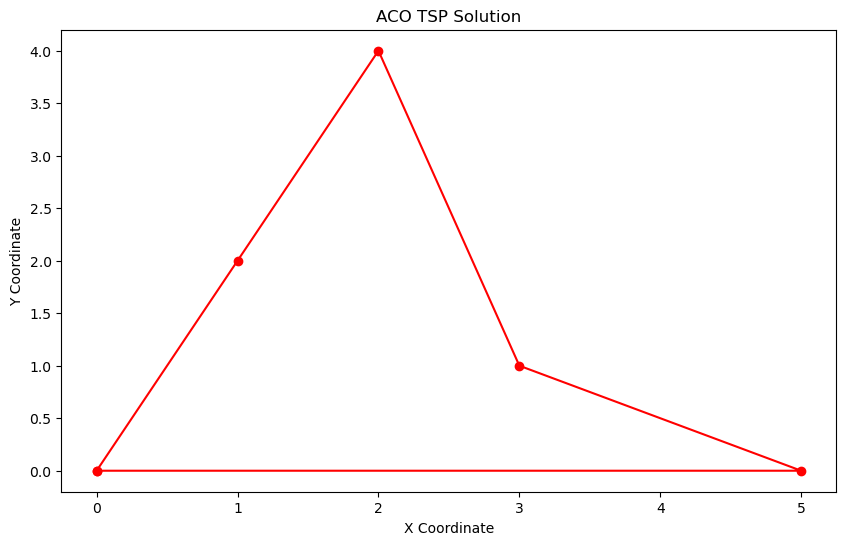

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Example TSP problem: Cities and distances between them
class ACO_TSP:
    def __init__(self, cities, n_ants, n_best, n_iterations, decay, alpha=1, beta=2):
        self.n_ants = n_ants  # Number of ants
        self.n_best = n_best  # Number of best ants to deposit pheromone
        self.n_iterations = n_iterations  # Number of iterations
        self.decay = decay  # Pheromone decay rate
        self.alpha = alpha  # Influence of pheromone on direction
        self.beta = beta  # Influence of distance on direction
        
        self.cities = cities  # Cities' coordinates
        self.distances = self.calculate_distances(cities)  # Distance matrix
        self.pheromone = [[1 for _ in range(len(cities))] for _ in range(len(cities))]  # Initialize pheromone matrix
        self.best_distance = float('inf')  # Best distance found
        self.best_solution = None  # Best solution path

    def calculate_distances(self, cities):
        """Calculate the distance matrix for cities."""
        distances = [[0 for _ in range(len(cities))] for _ in range(len(cities))]
        for i in range(len(cities)):
            for j in range(len(cities)):
                if i != j:
                    distances[i][j] = math.sqrt((cities[i][0] - cities[j][0]) ** 2 + (cities[i][1] - cities[j][1]) ** 2)
        return distances

    def select_next_city(self, ant, visited):
        """Select the next city to visit using pheromone and distance."""
        current_city = ant[-1]
        probabilities = []
        for i in range(len(self.cities)):
            if i not in visited:
                pheromone = self.pheromone[current_city][i] ** self.alpha
                distance = self.distances[current_city][i] ** -self.beta
                probabilities.append(pheromone * distance)
            else:
                probabilities.append(0)
        total = sum(probabilities)
        probabilities = [prob / total for prob in probabilities]  # Normalize
        return random.choices(range(len(self.cities)), probabilities)[0]

    def update_pheromone(self, all_ants):
        """Update pheromones on the paths."""
        pheromone_update = [[0 for _ in range(len(self.cities))] for _ in range(len(self.cities))]
        for ant in all_ants:
            distance = self.calculate_total_distance(ant)
            for i in range(len(ant) - 1):
                pheromone_update[ant[i]][ant[i + 1]] += 1 / distance
        for i in range(len(self.pheromone)):
            for j in range(len(self.pheromone)):
                self.pheromone[i][j] = (1 - self.decay) * self.pheromone[i][j] + pheromone_update[i][j]

    def calculate_total_distance(self, ant):
        """Calculate the total distance of a given solution (ant's path)."""
        distance = 0
        for i in range(len(ant) - 1):
            distance += self.distances[ant[i]][ant[i + 1]]
        distance += self.distances[ant[-1]][ant[0]]  # Returning to the start
        return distance

    def run(self):
        """Run the Ant Colony Optimization algorithm."""
        for _ in range(self.n_iterations):
            all_ants = []
            for _ in range(self.n_ants):
                ant = [random.randint(0, len(self.cities)-1)]  # Start at a random city
                visited = set(ant)
                while len(ant) < len(self.cities):
                    next_city = self.select_next_city(ant, visited)
                    visited.add(next_city)
                    ant.append(next_city)
                all_ants.append(ant)

            # Update pheromone matrix based on the ants' solutions
            self.update_pheromone(all_ants)
            
            # Evaluate the best solution from the ants
            for ant in all_ants:
                distance = self.calculate_total_distance(ant)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = ant

        # Return the best solution found
        return self.best_solution, self.best_distance

    def plot_solution(self):
        """Plot the best solution path on a 2D plot."""
        x = [self.cities[i][0] for i in self.best_solution]
        y = [self.cities[i][1] for i in self.best_solution]
        x.append(x[0])  # to return to the starting city
        y.append(y[0])

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'o-', color='r')
        plt.title("ACO TSP Solution")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# Example usage:
# Define 5 cities with their coordinates (x, y)
cities = [(0, 0), (1, 2), (2, 4), (3, 1), (5, 0)]

# Set up the ACO parameters
aco = ACO_TSP(cities, n_ants=10, n_best=3, n_iterations=100, decay=0.95)

# Run the ACO algorithm
best_solution, best_distance = aco.run()

# Display the best path and its distance
print("Best path:", best_solution)
print("Best distance:", best_distance)

# Plot the best solution
aco.plot_solution()


Iteration 1/100, Best Length: 17.469413449533644
Iteration 2/100, Best Length: 17.469413449533644
Iteration 3/100, Best Length: 17.469413449533644
Iteration 4/100, Best Length: 17.469413449533644
Iteration 5/100, Best Length: 17.469413449533644
Iteration 6/100, Best Length: 15.803263984955835
Iteration 7/100, Best Length: 15.803263984955835
Iteration 8/100, Best Length: 15.803263984955835
Iteration 9/100, Best Length: 15.803263984955835
Iteration 10/100, Best Length: 15.803263984955835
Iteration 11/100, Best Length: 15.803263984955835
Iteration 12/100, Best Length: 15.803263984955835
Iteration 13/100, Best Length: 15.803263984955835
Iteration 14/100, Best Length: 15.803263984955835
Iteration 15/100, Best Length: 15.803263984955835
Iteration 16/100, Best Length: 15.803263984955835
Iteration 17/100, Best Length: 15.803263984955835
Iteration 18/100, Best Length: 15.803263984955835
Iteration 19/100, Best Length: 15.803263984955835
Iteration 20/100, Best Length: 15.803263984955835
Iteration

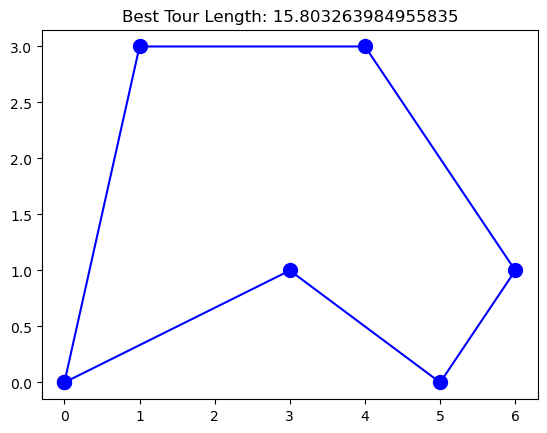

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

class AntColony:
    def __init__(self, cities, n_ants, n_iterations, alpha, beta, rho, q0, seed=None):
        self.cities = cities
        self.n_cities = len(cities)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # distance priority
        self.rho = rho      # pheromone evaporation rate
        self.q0 = q0        # probability for exploitation vs exploration
        self.pheromone = np.ones((self.n_cities, self.n_cities))  # initial pheromone matrix
        self.distances = self.calculate_distances(cities)
        self.best_tour = None
        self.best_tour_length = float('inf')
        self.random = random.Random(seed)

    def calculate_distances(self, cities):
        # Calculate Euclidean distance between cities
        distances = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(i+1, self.n_cities):
                dist = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))
                distances[i][j] = distances[j][i] = dist
        return distances

    def choose_next_city(self, ant, visited):
        # Probability of choosing the next city based on pheromone and distance
        current_city = ant[-1]
        probabilities = np.zeros(self.n_cities)

        for next_city in range(self.n_cities):
            if next_city not in visited:
                pheromone = self.pheromone[current_city][next_city] ** self.alpha
                distance = (1.0 / self.distances[current_city][next_city]) ** self.beta
                probabilities[next_city] = pheromone * distance

        # Normalize the probabilities
        total = sum(probabilities)
        if total == 0:
            probabilities = np.ones(self.n_cities) / self.n_cities
        else:
            probabilities /= total

        # Exploitation vs Exploration
        if self.random.random() < self.q0:
            # Exploitation: Choose the best city based on pheromone and distance
            next_city = np.argmax(probabilities)
        else:
            # Exploration: Choose randomly based on probabilities
            next_city = np.random.choice(range(self.n_cities), p=probabilities)

        return next_city

    def update_pheromone(self, ants):
        # Global pheromone update rule
        for i in range(self.n_cities):
            for j in range(i+1, self.n_cities):
                self.pheromone[i][j] *= (1 - self.rho)
                self.pheromone[j][i] *= (1 - self.rho)

        for ant in ants:
            tour_length = self.calculate_tour_length(ant)
            for i in range(len(ant) - 1):
                self.pheromone[ant[i]][ant[i + 1]] += 1.0 / tour_length
                self.pheromone[ant[i + 1]][ant[i]] += 1.0 / tour_length

    def calculate_tour_length(self, tour):
        length = 0
        for i in range(len(tour) - 1):
            length += self.distances[tour[i]][tour[i + 1]]
        length += self.distances[tour[-1]][tour[0]]  # return to the starting city
        return length

    def run(self):
        for iteration in range(self.n_iterations):
            ants = []

            # Each ant builds a tour
            for _ in range(self.n_ants):
                ant = [self.random.randint(0, self.n_cities - 1)]  # start from a random city
                visited = set(ant)
                while len(ant) < self.n_cities:
                    next_city = self.choose_next_city(ant, visited)
                    ant.append(next_city)
                    visited.add(next_city)
                ants.append(ant)

            # Update pheromone based on the ants' tours
            self.update_pheromone(ants)

            # Check for the best tour
            for ant in ants:
                tour_length = self.calculate_tour_length(ant)
                if tour_length < self.best_tour_length:
                    self.best_tour = ant
                    self.best_tour_length = tour_length

            print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Length: {self.best_tour_length}")

        return self.best_tour, self.best_tour_length

    def plot(self):
        # Plotting the best tour
        if self.best_tour:
            best_cities = [self.cities[i] for i in self.best_tour]
            best_cities.append(best_cities[0])  # close the tour

            best_cities = np.array(best_cities)
            plt.plot(best_cities[:, 0], best_cities[:, 1], 'bo-', markersize=10)
            plt.title(f"Best Tour Length: {self.best_tour_length}")
            plt.show()

# Example usage:

# Define cities as (x, y) coordinates
cities = [(0, 0), (1, 3), (4, 3), (6, 1), (5, 0), (3, 1)]

# Set parameters for the Ant Colony Optimization
n_ants = 10
n_iterations = 100
alpha = 1.0  # pheromone importance
beta = 2.0   # distance priority
rho = 0.1    # pheromone evaporation rate
q0 = 0.9     # probability for exploitation vs exploration

# Create the Ant Colony object
ant_colony = AntColony(cities, n_ants, n_iterations, alpha, beta, rho, q0)

# Run the algorithm
best_tour, best_tour_length = ant_colony.run()

# Print the result
print("Best Tour:", best_tour)
print("Best Tour Length:", best_tour_length)

# Plot the best tour
ant_colony.plot()


## Multi-objective Artificial Bee Colony Algorithms

The **Artificial Bee Colony (ABC)** algorithm, proposed by Karaboga in 2005, is inspired by the intelligent foraging behavior of honey bee swarms. The algorithm is simple, easy to implement, and competitive in terms of performance. The algorithm divides the colony into three types of bees: employed bees, onlooker bees, and scout bees. 

### Problem Representation

Let the position of a food source $ x_i = [x_{i,1}, x_{i,2}, \dots, x_{i,D}]^T $ represent a possible solution to the optimization problem. The **nectar amount** of the food source corresponds to the fitness of the associated solution. The population of $ SN $ food solutions (or individuals) is denoted by $ P = \{x_1, x_2, \dots, x_{SN}\} $, where each food source has $ D $ dimensions.

### Initialization

The initial population of solutions (food source positions) is randomly generated. The position of the $ i $-th food source is given by:

$$
x_{i,j} = x_{\text{min},j} + U(0, 1)(x_{\text{max},j} - x_{\text{min},j})
$$

where $i = 1, 2, \dots, SN $, $ j = 1, 2, \dots, D $, $ D $ is the number of optimization parameters, $ x_{\text{min},j} $ and $ x_{\text{max},j} $ are the lower and upper bounds for the dimension $ j $, and $ U(0, 1) $is a random number uniformly distributed in the range (0, 1).

### ABC Algorithm Process

The ABC algorithm follows the three steps below for each cycle:

1. **Employed Bees**: 
   - The employed bees explore the nectar sources and share their information with the onlookers. 
   - An employed bee updates its position using the following equation:

   $$
   v_{i,j} = x_{i,j} + \phi_{i,j}(x_{i,j} - x_{l,j})
   $$

   where $ l \neq i $, $ \phi_{i,j} $ is a random number in the range $ [-1, 1] $, and $ x_{l,j} $ is the position of a randomly selected food source $ l $.

2. **Onlooker Bees**: 
   - The onlooker bees select food sources based on the probability $ p_i $ of each food source, which is calculated by the fitness function:

   $$
   p_i = \frac{f(x_i)}{\sum_{j=1}^{SN} f(x_j)}
   $$

   where $ f(x_i) $ represents the fitness value of the $ i $-th solution. The onlooker bees use the shared information to further explore the food sources.

3. **Scout Bees**: 
   - If the position of a food source cannot be improved within a predetermined number of cycles (called the **limit for abandonment**), the food source is abandoned, and the employed bee becomes a scout. The scout bee randomly generates a new food source to replace the abandoned position.

### Termination Criteria

The algorithm iterates through cycles until a stopping criterion is met, such as a maximum number of iterations or a convergence threshold. The best food source found during the process is considered the optimal solution.

### Summary of the ABC Algorithm

Algorithm  summarizes the framework of the ABC algorithm:

1. **Initialization**: Generate an initial population of food sources.
2. **Employed Bee Phase**: Update the positions of the employed bees.
3. **Onlooker Bee Phase**: Update the positions of the onlooker bees based on their probabilities.
4. **Scout Bee Phase**: Abandon food sources that cannot be improved and generate new ones.
5. **Repeat**: Repeat the above steps until the termination criteria are satisfied.
6. **Output**: Return the best solution found.

### Conclusion

The **ABC algorithm** provides a robust optimization technique inspired by the natural foraging behavior of honey bees. By using a simple, population-based approach with a few parameters, it has shown promising results in solving various optimization problems. However, it may still face challenges with convergence, especially in more complex problems, where multi-objective variants of the algorithm can be applied for improved performance.


In [3]:
import numpy as np

# Objective function (to be optimized)
def objective_function(x):
    # Example: Sphere function, can be replaced with any other objective
    return np.sum(x**2)

# Initialize the population
def initialize_population(SN, D, xmin, xmax):
    population = np.random.uniform(low=xmin, high=xmax, size=(SN, D))
    return population

# Employed Bee Phase
def employed_bee_phase(population, fitness, xmin, xmax, limit, max_iter):
    for i in range(len(population)):
        x_old = population[i]
        fitness_old = fitness[i]

        # Generate a candidate solution in the neighborhood of x_old
        j = np.random.randint(0, len(population))  # Randomly pick a different individual
        phi = np.random.uniform(-1, 1, size=x_old.shape)
        x_new = x_old + phi * (x_old - population[j])

        # Apply boundary constraints
        x_new = np.clip(x_new, xmin, xmax)

        # Calculate fitness for the new solution
        fitness_new = objective_function(x_new)

        # If the new solution is better, replace the old solution
        if fitness_new < fitness_old:
            population[i] = x_new
            fitness[i] = fitness_new
        else:
            # If not improved, keep the old solution (exploration)
            pass
    return population, fitness

# Onlooker Bee Phase
def onlooker_bee_phase(population, fitness, SN, xmin, xmax):
    prob = fitness / np.sum(fitness)  # Calculate selection probability
    prob = prob / np.sum(prob)  # Normalize the probability values

    for i in range(SN):
        # Select a food source based on the probability
        if np.random.rand() < prob[i]:
            # Generate a new candidate solution
            j = np.random.randint(0, len(population))  # Randomly pick another individual
            phi = np.random.uniform(-1, 1, size=population[i].shape)
            x_new = population[i] + phi * (population[i] - population[j])

            # Apply boundary constraints
            x_new = np.clip(x_new, xmin, xmax)

            # Calculate fitness for the new solution
            fitness_new = objective_function(x_new)

            # If the new solution is better, replace the old solution
            if fitness_new < fitness[i]:
                population[i] = x_new
                fitness[i] = fitness_new

    return population, fitness

# Scout Bee Phase
def scout_bee_phase(population, fitness, limit, max_iter, SN, xmin, xmax):
    for i in range(SN):
        if fitness[i] > limit:
            # Abandon the food source, and generate a new solution randomly
            population[i] = np.random.uniform(low=xmin, high=xmax, size=population[i].shape)
            fitness[i] = objective_function(population[i])
    return population, fitness

# ABC Algorithm
def artificial_bee_colony(SN, D, xmin, xmax, max_iter, limit):
    # Initialize population
    population = initialize_population(SN, D, xmin, xmax)
    fitness = np.array([objective_function(ind) for ind in population])

    best_solution = population[np.argmin(fitness)]
    best_fitness = np.min(fitness)

    for iter in range(max_iter):
        # Employed Bee Phase
        population, fitness = employed_bee_phase(population, fitness, xmin, xmax, limit, max_iter)

        # Onlooker Bee Phase
        population, fitness = onlooker_bee_phase(population, fitness, SN, xmin, xmax)

        # Scout Bee Phase
        population, fitness = scout_bee_phase(population, fitness, limit, max_iter, SN, xmin, xmax)

        # Track the best solution
        current_best_fitness = np.min(fitness)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[np.argmin(fitness)]

        print(f"Iteration {iter+1}/{max_iter}, Best Fitness: {best_fitness}")

    return best_solution, best_fitness

# Example usage
if __name__ == "__main__":
    # Set problem parameters
    SN = 50  # Population size
    D = 30   # Dimension of the problem
    xmin = -5.12  # Lower bound of the search space
    xmax = 5.12   # Upper bound of the search space
    max_iter = 1000  # Maximum number of iterations
    limit = 100  # Abandonment limit

    # Run the ABC algorithm
    best_solution, best_fitness = artificial_bee_colony(SN, D, xmin, xmax, max_iter, limit)
    print("Best solution found:", best_solution)
    print("Best fitness:", best_fitness)


Iteration 1/1000, Best Fitness: 153.79778781666323
Iteration 2/1000, Best Fitness: 153.79778781666323
Iteration 3/1000, Best Fitness: 153.79778781666323
Iteration 4/1000, Best Fitness: 153.79778781666323
Iteration 5/1000, Best Fitness: 153.79778781666323
Iteration 6/1000, Best Fitness: 153.79778781666323
Iteration 7/1000, Best Fitness: 153.79778781666323
Iteration 8/1000, Best Fitness: 153.79778781666323
Iteration 9/1000, Best Fitness: 153.79778781666323
Iteration 10/1000, Best Fitness: 153.79778781666323
Iteration 11/1000, Best Fitness: 153.79778781666323
Iteration 12/1000, Best Fitness: 153.79778781666323
Iteration 13/1000, Best Fitness: 153.79778781666323
Iteration 14/1000, Best Fitness: 138.79181016080705
Iteration 15/1000, Best Fitness: 138.79181016080705
Iteration 16/1000, Best Fitness: 138.79181016080705
Iteration 17/1000, Best Fitness: 138.79181016080705
Iteration 18/1000, Best Fitness: 138.79181016080705
Iteration 19/1000, Best Fitness: 138.79181016080705
Iteration 20/1000, Be

Iteration 194/1000, Best Fitness: 123.50620519529619
Iteration 195/1000, Best Fitness: 123.50620519529619
Iteration 196/1000, Best Fitness: 123.50620519529619
Iteration 197/1000, Best Fitness: 123.50620519529619
Iteration 198/1000, Best Fitness: 123.50620519529619
Iteration 199/1000, Best Fitness: 123.50620519529619
Iteration 200/1000, Best Fitness: 123.50620519529619
Iteration 201/1000, Best Fitness: 123.50620519529619
Iteration 202/1000, Best Fitness: 123.50620519529619
Iteration 203/1000, Best Fitness: 123.50620519529619
Iteration 204/1000, Best Fitness: 123.50620519529619
Iteration 205/1000, Best Fitness: 123.50620519529619
Iteration 206/1000, Best Fitness: 123.50620519529619
Iteration 207/1000, Best Fitness: 123.50620519529619
Iteration 208/1000, Best Fitness: 123.50620519529619
Iteration 209/1000, Best Fitness: 123.50620519529619
Iteration 210/1000, Best Fitness: 123.50620519529619
Iteration 211/1000, Best Fitness: 123.50620519529619
Iteration 212/1000, Best Fitness: 123.50620519

Iteration 349/1000, Best Fitness: 123.50620519529619
Iteration 350/1000, Best Fitness: 123.50620519529619
Iteration 351/1000, Best Fitness: 123.50620519529619
Iteration 352/1000, Best Fitness: 123.50620519529619
Iteration 353/1000, Best Fitness: 123.50620519529619
Iteration 354/1000, Best Fitness: 123.50620519529619
Iteration 355/1000, Best Fitness: 123.50620519529619
Iteration 356/1000, Best Fitness: 123.50620519529619
Iteration 357/1000, Best Fitness: 123.50620519529619
Iteration 358/1000, Best Fitness: 123.50620519529619
Iteration 359/1000, Best Fitness: 123.50620519529619
Iteration 360/1000, Best Fitness: 123.50620519529619
Iteration 361/1000, Best Fitness: 123.50620519529619
Iteration 362/1000, Best Fitness: 123.50620519529619
Iteration 363/1000, Best Fitness: 123.50620519529619
Iteration 364/1000, Best Fitness: 123.50620519529619
Iteration 365/1000, Best Fitness: 123.50620519529619
Iteration 366/1000, Best Fitness: 123.50620519529619
Iteration 367/1000, Best Fitness: 123.50620519

Iteration 523/1000, Best Fitness: 101.98121812533618
Iteration 524/1000, Best Fitness: 101.98121812533618
Iteration 525/1000, Best Fitness: 101.98121812533618
Iteration 526/1000, Best Fitness: 101.98121812533618
Iteration 527/1000, Best Fitness: 101.98121812533618
Iteration 528/1000, Best Fitness: 101.98121812533618
Iteration 529/1000, Best Fitness: 101.98121812533618
Iteration 530/1000, Best Fitness: 101.98121812533618
Iteration 531/1000, Best Fitness: 101.98121812533618
Iteration 532/1000, Best Fitness: 101.98121812533618
Iteration 533/1000, Best Fitness: 101.98121812533618
Iteration 534/1000, Best Fitness: 101.98121812533618
Iteration 535/1000, Best Fitness: 101.98121812533618
Iteration 536/1000, Best Fitness: 101.98121812533618
Iteration 537/1000, Best Fitness: 101.98121812533618
Iteration 538/1000, Best Fitness: 101.98121812533618
Iteration 539/1000, Best Fitness: 101.98121812533618
Iteration 540/1000, Best Fitness: 101.98121812533618
Iteration 541/1000, Best Fitness: 101.98121812

Iteration 710/1000, Best Fitness: 76.29083739961303
Iteration 711/1000, Best Fitness: 76.29083739961303
Iteration 712/1000, Best Fitness: 76.29083739961303
Iteration 713/1000, Best Fitness: 76.29083739961303
Iteration 714/1000, Best Fitness: 76.29083739961303
Iteration 715/1000, Best Fitness: 76.29083739961303
Iteration 716/1000, Best Fitness: 76.29083739961303
Iteration 717/1000, Best Fitness: 76.29083739961303
Iteration 718/1000, Best Fitness: 76.29083739961303
Iteration 719/1000, Best Fitness: 76.29083739961303
Iteration 720/1000, Best Fitness: 76.29083739961303
Iteration 721/1000, Best Fitness: 76.29083739961303
Iteration 722/1000, Best Fitness: 76.29083739961303
Iteration 723/1000, Best Fitness: 76.29083739961303
Iteration 724/1000, Best Fitness: 76.29083739961303
Iteration 725/1000, Best Fitness: 76.29083739961303
Iteration 726/1000, Best Fitness: 76.29083739961303
Iteration 727/1000, Best Fitness: 76.29083739961303
Iteration 728/1000, Best Fitness: 76.29083739961303
Iteration 72

Iteration 891/1000, Best Fitness: 76.20689149137112
Iteration 892/1000, Best Fitness: 76.20689149137112
Iteration 893/1000, Best Fitness: 76.20689149137112
Iteration 894/1000, Best Fitness: 76.20689149137112
Iteration 895/1000, Best Fitness: 76.20689149137112
Iteration 896/1000, Best Fitness: 76.20689149137112
Iteration 897/1000, Best Fitness: 76.20689149137112
Iteration 898/1000, Best Fitness: 76.20689149137112
Iteration 899/1000, Best Fitness: 76.20689149137112
Iteration 900/1000, Best Fitness: 76.20689149137112
Iteration 901/1000, Best Fitness: 76.20689149137112
Iteration 902/1000, Best Fitness: 76.20689149137112
Iteration 903/1000, Best Fitness: 76.20689149137112
Iteration 904/1000, Best Fitness: 76.20689149137112
Iteration 905/1000, Best Fitness: 76.20689149137112
Iteration 906/1000, Best Fitness: 76.20689149137112
Iteration 907/1000, Best Fitness: 76.20689149137112
Iteration 908/1000, Best Fitness: 76.20689149137112
Iteration 909/1000, Best Fitness: 76.20689149137112
Iteration 91

In [4]:
import random

# Objective function (to be optimized)
def objective_function(x):
    # Example: Sphere function (sum of squares)
    return sum([xi**2 for xi in x])

# Initialize the population
def initialize_population(SN, D, xmin, xmax):
    population = []
    for _ in range(SN):
        individual = [random.uniform(xmin, xmax) for _ in range(D)]
        population.append(individual)
    return population

# Employed Bee Phase
def employed_bee_phase(population, fitness, xmin, xmax, limit, max_iter):
    for i in range(len(population)):
        x_old = population[i]
        fitness_old = fitness[i]

        # Generate a candidate solution in the neighborhood of x_old
        j = random.randint(0, len(population) - 1)  # Randomly pick a different individual
        phi = [random.uniform(-1, 1) for _ in range(len(x_old))]
        x_new = [x_old[k] + phi[k] * (x_old[k] - population[j][k]) for k in range(len(x_old))]

        # Apply boundary constraints
        x_new = [min(max(x_new[k], xmin), xmax) for k in range(len(x_new))]

        # Calculate fitness for the new solution
        fitness_new = objective_function(x_new)

        # If the new solution is better, replace the old solution
        if fitness_new < fitness_old:
            population[i] = x_new
            fitness[i] = fitness_new
        else:
            pass  # If not improved, keep the old solution
    return population, fitness

# Onlooker Bee Phase
def onlooker_bee_phase(population, fitness, SN, xmin, xmax):
    total_fitness = sum(fitness)
    prob = [f / total_fitness for f in fitness]  # Calculate selection probability

    for i in range(SN):
        # Select a food source based on the probability
        if random.random() < prob[i]:
            # Generate a new candidate solution
            j = random.randint(0, len(population) - 1)  # Randomly pick another individual
            phi = [random.uniform(-1, 1) for _ in range(len(population[i]))]
            x_new = [population[i][k] + phi[k] * (population[i][k] - population[j][k]) for k in range(len(population[i]))]

            # Apply boundary constraints
            x_new = [min(max(x_new[k], xmin), xmax) for k in range(len(x_new))]

            # Calculate fitness for the new solution
            fitness_new = objective_function(x_new)

            # If the new solution is better, replace the old solution
            if fitness_new < fitness[i]:
                population[i] = x_new
                fitness[i] = fitness_new

    return population, fitness

# Scout Bee Phase
def scout_bee_phase(population, fitness, limit, SN, xmin, xmax):
    for i in range(SN):
        if fitness[i] > limit:
            # Abandon the food source, and generate a new solution randomly
            population[i] = [random.uniform(xmin, xmax) for _ in range(len(population[i]))]
            fitness[i] = objective_function(population[i])
    return population, fitness

# ABC Algorithm
def artificial_bee_colony(SN, D, xmin, xmax, max_iter, limit):
    # Initialize population
    population = initialize_population(SN, D, xmin, xmax)
    fitness = [objective_function(ind) for ind in population]

    best_solution = population[fitness.index(min(fitness))]
    best_fitness = min(fitness)

    for iter in range(max_iter):
        # Employed Bee Phase
        population, fitness = employed_bee_phase(population, fitness, xmin, xmax, limit, max_iter)

        # Onlooker Bee Phase
        population, fitness = onlooker_bee_phase(population, fitness, SN, xmin, xmax)

        # Scout Bee Phase
        population, fitness = scout_bee_phase(population, fitness, limit, SN, xmin, xmax)

        # Track the best solution
        current_best_fitness = min(fitness)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[fitness.index(best_fitness)]

        print(f"Iteration {iter+1}/{max_iter}, Best Fitness: {best_fitness}")

    return best_solution, best_fitness

# Example usage
if __name__ == "__main__":
    # Set problem parameters
    SN = 50  # Population size
    D = 30   # Dimension of the problem
    xmin = -5.12  # Lower bound of the search space
    xmax = 5.12   # Upper bound of the search space
    max_iter = 1000  # Maximum number of iterations
    limit = 100  # Abandonment limit

    # Run the ABC algorithm
    best_solution, best_fitness = artificial_bee_colony(SN, D, xmin, xmax, max_iter, limit)
    print("Best solution found:", best_solution)
    print("Best fitness:", best_fitness)


Iteration 1/1000, Best Fitness: 146.50910069106823
Iteration 2/1000, Best Fitness: 146.50910069106823
Iteration 3/1000, Best Fitness: 146.50910069106823
Iteration 4/1000, Best Fitness: 146.50910069106823
Iteration 5/1000, Best Fitness: 146.50910069106823
Iteration 6/1000, Best Fitness: 146.50910069106823
Iteration 7/1000, Best Fitness: 146.50910069106823
Iteration 8/1000, Best Fitness: 146.50910069106823
Iteration 9/1000, Best Fitness: 146.50910069106823
Iteration 10/1000, Best Fitness: 146.50910069106823
Iteration 11/1000, Best Fitness: 146.50910069106823
Iteration 12/1000, Best Fitness: 146.50910069106823
Iteration 13/1000, Best Fitness: 140.87013523569024
Iteration 14/1000, Best Fitness: 140.87013523569024
Iteration 15/1000, Best Fitness: 140.87013523569024
Iteration 16/1000, Best Fitness: 140.87013523569024
Iteration 17/1000, Best Fitness: 140.87013523569024
Iteration 18/1000, Best Fitness: 140.87013523569024
Iteration 19/1000, Best Fitness: 140.87013523569024
Iteration 20/1000, Be

Iteration 172/1000, Best Fitness: 98.85208579166361
Iteration 173/1000, Best Fitness: 98.85208579166361
Iteration 174/1000, Best Fitness: 98.85208579166361
Iteration 175/1000, Best Fitness: 98.85208579166361
Iteration 176/1000, Best Fitness: 98.85208579166361
Iteration 177/1000, Best Fitness: 98.85208579166361
Iteration 178/1000, Best Fitness: 98.85208579166361
Iteration 179/1000, Best Fitness: 98.85208579166361
Iteration 180/1000, Best Fitness: 98.85208579166361
Iteration 181/1000, Best Fitness: 98.85208579166361
Iteration 182/1000, Best Fitness: 98.85208579166361
Iteration 183/1000, Best Fitness: 98.85208579166361
Iteration 184/1000, Best Fitness: 98.85208579166361
Iteration 185/1000, Best Fitness: 98.85208579166361
Iteration 186/1000, Best Fitness: 98.85208579166361
Iteration 187/1000, Best Fitness: 98.85208579166361
Iteration 188/1000, Best Fitness: 98.85208579166361
Iteration 189/1000, Best Fitness: 98.85208579166361
Iteration 190/1000, Best Fitness: 98.85208579166361
Iteration 19

Iteration 359/1000, Best Fitness: 71.24904912383874
Iteration 360/1000, Best Fitness: 71.24904912383874
Iteration 361/1000, Best Fitness: 71.24904912383874
Iteration 362/1000, Best Fitness: 71.24904912383874
Iteration 363/1000, Best Fitness: 71.24904912383874
Iteration 364/1000, Best Fitness: 71.24904912383874
Iteration 365/1000, Best Fitness: 71.24904912383874
Iteration 366/1000, Best Fitness: 71.24904912383874
Iteration 367/1000, Best Fitness: 71.24904912383874
Iteration 368/1000, Best Fitness: 71.24904912383874
Iteration 369/1000, Best Fitness: 71.24904912383874
Iteration 370/1000, Best Fitness: 71.24904912383874
Iteration 371/1000, Best Fitness: 71.24904912383874
Iteration 372/1000, Best Fitness: 71.24904912383874
Iteration 373/1000, Best Fitness: 71.24904912383874
Iteration 374/1000, Best Fitness: 71.24904912383874
Iteration 375/1000, Best Fitness: 71.24904912383874
Iteration 376/1000, Best Fitness: 71.24904912383874
Iteration 377/1000, Best Fitness: 71.24904912383874
Iteration 37

Iteration 526/1000, Best Fitness: 71.24904912383874
Iteration 527/1000, Best Fitness: 71.24904912383874
Iteration 528/1000, Best Fitness: 71.24904912383874
Iteration 529/1000, Best Fitness: 71.24904912383874
Iteration 530/1000, Best Fitness: 71.24904912383874
Iteration 531/1000, Best Fitness: 71.24904912383874
Iteration 532/1000, Best Fitness: 71.24904912383874
Iteration 533/1000, Best Fitness: 71.24904912383874
Iteration 534/1000, Best Fitness: 71.24904912383874
Iteration 535/1000, Best Fitness: 71.24904912383874
Iteration 536/1000, Best Fitness: 71.24904912383874
Iteration 537/1000, Best Fitness: 71.24904912383874
Iteration 538/1000, Best Fitness: 71.24904912383874
Iteration 539/1000, Best Fitness: 71.24904912383874
Iteration 540/1000, Best Fitness: 71.24904912383874
Iteration 541/1000, Best Fitness: 71.24904912383874
Iteration 542/1000, Best Fitness: 71.24904912383874
Iteration 543/1000, Best Fitness: 71.24904912383874
Iteration 544/1000, Best Fitness: 71.24904912383874
Iteration 54

Iteration 688/1000, Best Fitness: 71.24904912383874
Iteration 689/1000, Best Fitness: 71.24904912383874
Iteration 690/1000, Best Fitness: 71.24904912383874
Iteration 691/1000, Best Fitness: 71.24904912383874
Iteration 692/1000, Best Fitness: 71.24904912383874
Iteration 693/1000, Best Fitness: 71.24904912383874
Iteration 694/1000, Best Fitness: 71.24904912383874
Iteration 695/1000, Best Fitness: 71.24904912383874
Iteration 696/1000, Best Fitness: 71.24904912383874
Iteration 697/1000, Best Fitness: 71.24904912383874
Iteration 698/1000, Best Fitness: 71.24904912383874
Iteration 699/1000, Best Fitness: 71.24904912383874
Iteration 700/1000, Best Fitness: 71.24904912383874
Iteration 701/1000, Best Fitness: 71.24904912383874
Iteration 702/1000, Best Fitness: 71.24904912383874
Iteration 703/1000, Best Fitness: 71.24904912383874
Iteration 704/1000, Best Fitness: 71.24904912383874
Iteration 705/1000, Best Fitness: 71.24904912383874
Iteration 706/1000, Best Fitness: 71.24904912383874
Iteration 70

Iteration 856/1000, Best Fitness: 71.24904912383874
Iteration 857/1000, Best Fitness: 71.24904912383874
Iteration 858/1000, Best Fitness: 71.24904912383874
Iteration 859/1000, Best Fitness: 71.24904912383874
Iteration 860/1000, Best Fitness: 71.24904912383874
Iteration 861/1000, Best Fitness: 71.24904912383874
Iteration 862/1000, Best Fitness: 71.24904912383874
Iteration 863/1000, Best Fitness: 71.24904912383874
Iteration 864/1000, Best Fitness: 71.24904912383874
Iteration 865/1000, Best Fitness: 71.24904912383874
Iteration 866/1000, Best Fitness: 71.24904912383874
Iteration 867/1000, Best Fitness: 71.24904912383874
Iteration 868/1000, Best Fitness: 71.24904912383874
Iteration 869/1000, Best Fitness: 71.24904912383874
Iteration 870/1000, Best Fitness: 71.24904912383874
Iteration 871/1000, Best Fitness: 71.24904912383874
Iteration 872/1000, Best Fitness: 71.24904912383874
Iteration 873/1000, Best Fitness: 71.24904912383874
Iteration 874/1000, Best Fitness: 71.24904912383874
Iteration 87

##  Variants of ABC Algorithms

The solution search equation of the ABC algorithm is good at exploration but poor at exploitation. To achieve better performance in optimization problems, both exploration and exploitation should be balanced. Several variants of ABC have been proposed to improve its performance.

### 1. GABC (gbest-guided Artificial Bee Colony)

The GABC algorithm incorporates the information of the **global best solution (gbest)** into the solution search equation to improve the exploitation capabilities of ABC. The solution search equation in GABC is given by:

$$
v_{ij} = x_{ij} + \phi_{ij} (x_{ij} - x_{kj}) + \psi_{ij} (g_j - x_{ij})
$$

Where:
- $ v_{ij} $ is the new candidate solution.
- $ x_{ij} $ is the current solution.
- $ x_{kj} $ is another randomly selected solution from the population.
- $ g_j $ is the $ j $-th element of the **global best solution**.
- $ \phi_{ij} $ is a random number in the range $[-1, 1]$.
- $ \psi_{ij} $ is a uniform random number in the range $[0, 1.5]$.

The introduction of the $ g_j - x_{ij} $ term helps improve the exploitation phase by guiding the search towards the global best solution.

### 2. IABC (Improved Artificial Bee Colony)

The IABC algorithm uses two different solution search equations to enhance both exploration and exploitation. These equations are:

#### Equation 1 (Exploitation):

$$
v_{ij} = g_{best,j} + \phi_{ij} (x_{ij} - x_{r1,j})
$$

Where:
- $ g_{best,j} $ is the $ j $-th element of the global best solution.
- $ x_{r1,j} $ is the $ j $-th element of a randomly chosen solution $ r1 $ from the population.
- $ \phi_{ij} $ is a random number in the range $[-1, 1]$.

This equation focuses on **exploitation** by generating a candidate solution around the global best solution $ g_{best,j} $.

#### Equation 2 (Exploration):

$$
v_{ij} = x_{r1,j} + \phi_{ij} (x_{ij} - x_{r2,j})
$$

Where:
- $ x_{r1,j} $ and $ x_{r2,j} $ are the $ j $-th elements of two different randomly selected solutions from the population.
- $ \phi_{ij} $ is a random number in the range $[-1, 1]$.

This equation emphasizes **exploration** by using two different randomly selected solutions to generate new candidate solutions.

### Algorithm Framework of ABC

The basic steps of the Artificial Bee Colony (ABC) algorithm are as follows:

1. **Initialization**:
    - Randomly generate $ S_N $ points in the search space to form the initial population.
    - Evaluate the objective value of the population.

2. **Employed Bee Phase**:
    - For each employed bee, generate a candidate solution $ v_i $.
    - If the new solution has a better objective value, replace the old one.

3. **Onlooker Bee Phase**:
    - Onlooker bees select food sources based on their probability of being selected.
    - Generate new candidate solutions and replace the old ones if they are better.

4. **Scout Bee Phase**:
    - If a solution is not improved after a certain number of cycles, it is abandoned.
    - A scout bee generates a new random solution to replace the abandoned solution.

5. **Termination**:
    - The algorithm terminates when a stopping condition is met, such as reaching the maximum number of cycles or the best solution found.

#### Pseudo-code (Algorithm 9.15):


In [ ]:
import random

# Objective function to be minimized (e.g., sphere function)
def objective_function(x):
    return sum([xi**2 for xi in x])

# Initialize the population with random values
def initialize_population(SN, D, xmin, xmax):
    population = []
    for _ in range(SN):
        individual = [random.uniform(xmin[j], xmax[j]) for j in range(D)]
        population.append(individual)
    return population

# Generate a new candidate solution for the employed bee
def generate_candidate_solution(x, xk, phi, xmin, xmax):
    # xk is a randomly selected individual
    return [x[j] + phi * (x[j] - xk[j]) for j in range(len(x))]

# GABC - gbest-guided solution search equation
def generate_gabc_solution(x, gbest, phi, psi, xmin, xmax):
    return [x[j] + phi * (x[j] - random.choice(gbest)[j]) + psi * (gbest[j] - x[j]) for j in range(len(x))]

# IABC - Improved ABC solution search equations
def generate_iabc_solution_1(x, gbest, phi, xmin, xmax):
    return [gbest[j] + phi * (x[j] - random.choice(gbest)[j]) for j in range(len(x))]

def generate_iabc_solution_2(x, xmin, xmax):
    r1, r2 = random.sample(range(len(x)), 2)
    return [x[r1] + phi * (x[j] - x[r2]) for j in range(len(x))]

# Update the population by replacing the worse solutions with new ones
def update_population(population, fitness_values, trial, limit):
    for i in range(len(population)):
        if fitness_values[i] < fitness_values[trial[i]]:
            population[i] = population[trial[i]]

def abc_algorithm(SN, D, xmin, xmax, max_iter, limit, algorithm_type="ABC"):
    population = initialize_population(SN, D, xmin, xmax)
    fitness_values = [objective_function(ind) for ind in population]
    trial = [0] * SN

    gbest = min(population, key=lambda ind: objective_function(ind))

    for iter in range(max_iter):
        # Employed Bee Phase
        for i in range(SN):
            # Randomly choose another individual xk from the population
            xk = population[random.randint(0, SN-1)]
            # Generate a candidate solution
            if algorithm_type == "GABC":
                phi = random.uniform(-1, 1)
                psi = random.uniform(0, 1.5)
                candidate = generate_gabc_solution(population[i], gbest, phi, psi, xmin, xmax)
            elif algorithm_type == "IABC":
                phi = random.uniform(-1, 1)
                candidate = generate_iabc_solution_1(population[i], gbest, phi, xmin, xmax)
            else:
                phi = random.uniform(-1, 1)
                candidate = generate_candidate_solution(population[i], xk, phi, xmin, xmax)

            candidate_fitness = objective_function(candidate)

            # If the candidate solution is better, replace the current solution
            if candidate_fitness < fitness_values[i]:
                population[i] = candidate
                fitness_values[i] = candidate_fitness
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker Bee Phase
        for i in range(SN):
            probability = fitness_values[i] / sum(fitness_values) # Probability based on fitness
            if random.random() < probability:
                # Generate a candidate solution using the employed bee phase update
                xk = population[random.randint(0, SN-1)]
                if algorithm_type == "GABC":
                    phi = random.uniform(-1, 1)
                    psi = random.uniform(0, 1.5)
                    candidate = generate_gabc_solution(population[i], gbest, phi, psi, xmin, xmax)
                elif algorithm_type == "IABC":
                    phi = random.uniform(-1, 1)
                    candidate = generate_iabc_solution_1(population[i], gbest, phi, xmin, xmax)
                else:
                    phi = random.uniform(-1, 1)
                    candidate = generate_candidate_solution(population[i], xk, phi, xmin, xmax)

                candidate_fitness = objective_function(candidate)

                # If the candidate solution is better, replace the current solution
                if candidate_fitness < fitness_values[i]:
                    population[i] = candidate
                    fitness_values[i] = candidate_fitness
                    trial[i] = 0
                else:
                    trial[i] += 1

        # Scout Bee Phase: Abandon the food source if not improved
        for i in range(SN):
            if trial[i] > limit:
                population[i] = [random.uniform(xmin[j], xmax[j]) for j in range(D)]
                fitness_values[i] = objective_function(population[i])
                trial[i] = 0

        # Update the global best solution
        best_solution = min(population, key=lambda ind: objective_function(ind))
        if objective_function(best_solution) < objective_function(gbest):
            gbest = best_solution

        # Stopping criteria
        if iter >= max_iter:
            break

    return gbest, objective_function(gbest)

# Parameters
SN = 50  # Number of solutions (bees)
D = 10   # Dimension of the problem
xmin = [-5] * D
xmax = [5] * D
max_iter = 1000  # Maximum number of iterations
limit = 100  # Limit for abandoning a food source

# Run the ABC algorithm
best_solution, best_fitness = abc_algorithm(SN, D, xmin, xmax, max_iter, limit, algorithm_type="IABC")
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)
